# FLIP (02) Optimization Data Science

---
Team Director: Meng Ren | mren@tulip.academy<br />

TULIP Academy <br />
http://www.tulip.academy 

---

Implicit Multistep Methods
==========================

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})

Looking at IVPs of the form

$${\boldsymbol{y}}'(x) = {\boldsymbol{f}}(x, {\boldsymbol{y}}(x)).$$

Looked at multistep methods using the $k$-step method formula

$$a_k y_{n+1} + a_{k-1} y_n + \dots + a_0 y_{n+1-k} = h \left[ b_k f_{n+1} + b_{k-1} f_n + \dots + b_0 f_{n+1-k} \right].$$

Explicit when $b_k = 0$, as in Adams-Bashforth methods. Even an explicit
multistep method still needs a different method to start; multistage
methods such as Runge-Kutta are typically used.

May want to use an *implicit* formula where $b_k \neq 0$. This may be
either for accuracy or stability, as we shall consider later.

Adams-Moulton Methods
---------------------

Compare the explicit Adams-Bashforth methods

$$y_{n+1} - y_n = h\left[ b_{k-1} f_n + b_{k-2} f_{n-1} + \dots \right]$$

with the *implicit* Adams-Moulton methods

$$y_{n+1} - y_n = h \left[ b_k f_{n+1} + b_{k-1} f_{n} + \dots \right]$$

 As before assume the $x_j$ are evenly spaced. Efficient
as function evaluations can be stored, but difficult to use with
adaptive step sizes. Formula cannot be used directly:
$f_{n+1}$ cannot be computed directly. 

Standard practice to use Adams-Moulton methods as part of a
predictor-correct method, where estimate $y^{(p)}_{n+1}$ is computed,
and then the unknown $f_{n+1}$ estimated as

$$f_{n+1} = f(x_{n+1}, y^{(p)}_{n+1}).$$

Typically use Adams-Bashforth as the predictor
(minimizes function evaluations), but any method (e.g. RK45) valid.

### Computing the coefficients

Computing the fixed coefficients $b_m$ is identical to Adams-Bashforth:
integrate the formula

$$y_{n+1} - y_n = h \left[ b_k f_{n+1} + b_{k-1} f_{n} + \dots b_1 f_{n+2-k} \right]$$

over the range, assuming $f(x) = p_s(x)$ for polynomials of degree
$s = 0, \dots k-1$.

As before we choose as a basis for the polynomials

$$p_s(x) = x (x + h) \dots (x + h (s-1))$$

as $p_s$ vanishes at $x = 0, -h, \dots, -h (s-1)$. Then choose
$x_{n+1} = 0, x_{n} = -h$ and so on: the resulting system of equations
is in upper-triangular form – solve by back substitution.

### Adams-Moulton example

The Adams-Moulton method of order 5 has formula

$$y_{n+1} - y_n = h \left[ b_5 f_{n+1} + b_4 f_{n} + b_3 f_{n-1} + b_2 f_{n-2} + b_1 f_{n-3} \right],$$

and the coefficients follow from

\begin{align}
p_0 & = 1: & h & = h \left[ b_5 + b_4 + b_3 + b_2 + b_1 \right] \\
p_1 & = x: & -\frac{h^2}{2} & = h \left[ -h \left( b_4 + 2 b_3 + 3
    b_2 + 4 b_1 \right) \right] \\
p_2 & = x (x + h): & -\frac{h^3}{6} & = h \left[ h^2 \left( 2 b_3
    + 6 b_2 + 12 b_1 \right) \right] \\ 
p_3 & = x (x + h) (x + 2 h): & -\frac{h^4}{4} & = h \left[ -h^3
  \left( 6 b_2 + 24 b_1 \right) \right] \\
p_4 & = x (x + h) (x + 2 h) (x + 3 h): & -19 \frac{h^5}{30} & = h
\left[ 24 h^4 b_1 \right].
\end{align}

### Standard example

Apply the 5 step Adams-Moulton method to

$$y'(x) = - \sin(x), \quad y(0) = 1$$

and integrate to $x = 0.5$. Use RK4 to start algorithm and
Adams-Bashforth 5 to predict. Using $h = 0.05$ gives

|$n$|$x_n$|$y_n$|$f(x_n, y_n)$|$\cos(x_n)$|
|---|-----|-----|-------------|-----------|
|0  | 0.0 |1.000| 0.000       | 1.000     |
|1  | 0.1 |0.995| -0.100      | 0.995     |
|2  | 0.2 |0.980| -0.199      | 0.980     |
|3  | 0.3 |0.955| -0.296      | 0.955     |
|4  | 0.4 |0.921| -0.389      | 0.921     |
|5  | 0.5 |0.878|             | 0.878     |

The error is is $2 \times 10^{-9}\%$, not visible at this precision.
With $h = 0.01$ the error is $0.9 \times 10^{-12}\%$. Convergence is
slightly worse than fifth order; result is slightly biased by the
starting method.

In [3]:
def am5_method(f, x_end, y0, N):
    """Solve IVP y'=f(x, y(x)) on x \in [0, x_end] with y(0) = y0 using N+1 points, using 5th order Adams-Moulton method."""
    
    h = x_end / N
    x = np.linspace(0.0, x_end, N+1)
    
    y = np.zeros((N+1, len(y0)))
    fn = np.zeros_like(y)
    y[0, :] = y0
    
    # Start using RK4 steps
    for n in range(4):
        fn[n, :] = f(x[n], y[n, :])
        k1 = h * fn[n, :]
        k2 = h * f(x[n] + h / 2.0, y[n, :] + k1 / 2.0)
        k3 = h * f(x[n] + h / 2.0, y[n, :] + k2 / 2.0)
        k4 = h * f(x[n] + h, y[n, :] + k3)
        y[n+1, :] = y[n, :] +  (k1 + k4 + 2.0 * (k2 + k3)) / 6.0
    
    # Solve for the coefficients
    
    coeff_A = np.array([[1.0, 1.0, 1.0, 1.0, 1.0],[0.0, -1.0, -2.0, -3.0, -4.0],[0.0, 0.0, 2.0, 6.0, 12.0],
                        [0.0, 0.0, 0.0, -6.0, -24.0],[0.0, 0.0, 0.0, 0.0, 24.0]])
    coeff_b = np.array([1.0, 1.0 / 2.0, 5.0/6.0, 9.0/4.0, 251.0/30.0])
    b_ab4 = np.linalg.solve(coeff_A, coeff_b)
    b_am5 = np.array([251.0, 646.0, -264.0, 106.0, -19.0])/720.0
    
    for n in range(4, N):
        fn[n, :] = f(x[n], y[n, :])
        yp = y[n, :] + h * (b_ab4[0]*fn[n, :] + b_ab4[1]*fn[n-1, :] + b_ab4[2]*fn[n-2, :] + 
                            b_ab4[3]*fn[n-3, :] + b_ab4[4]*fn[n-4, :])
        y[n+1, :] = y[n, :] + h * (b_am5[0]*f(x[n+1], yp) + b_am5[1]*fn[n, :] + b_am5[2]*fn[n-1, :] + 
                                   b_am5[3]*fn[n-2, :] + b_am5[4]*fn[n-3, :])
        
    return x, y

def fn_simple(x, y):
    """Simple function for example"""
    
    return -np.sin(x)

# Example given above
x_5, y_5 = am5_method(fn_simple, 0.5, [1.0], 5)
x_50, y_50 = am5_method(fn_simple, 0.5, [1.0], 50)

print("Solution at x = 0.5 using h = 0.1 is y = {}.".format(y_5[-1, 0]))
print("Error at x = 0.5 using h = 0.1 is y = {}.".format(abs(np.cos(0.5) - y_5[-1, 0])))
print("Solution at x = 0.5 using h = 0.01 is y = {}.".format(y_50[-1, 0]))
print("Error at x = 0.5 using h = 0.01 is y = {}.".format(abs(np.cos(0.5) - y_50[-1, 0])))

Solution at x = 0.5 using h = 0.1 is y = 0.877582541412.
Error at x = 0.5 using h = 0.1 is y = 2.04779130319e-08.
Solution at x = 0.5 using h = 0.01 is y = 0.87758256189.
Error at x = 0.5 using h = 0.01 is y = 8.2911455479e-13.


### Standard Example: 2

Consider the system

$$\left\{
\begin{aligned}
  \dot{x} & = -y \\ \dot{y} & = x
\end{aligned} \right., \quad x(0) = 1, \, \, y(0) = 0.$$

In polar coordinates this is $\dot{r} = 0$, $\dot{\phi} = 1$.

Use Adams-Moulton 5 step method with $h=0.1$. At
$t=500$ the result matches the correct answer to the eye. 

The growth of the radius makes the errors visible.

Use Adams-Moulton 5 step method with $h=0.01$. At
$t=500$ the result matches the correct answer to the eye.

Looking at the growth of the radius makes the errors visible even now.

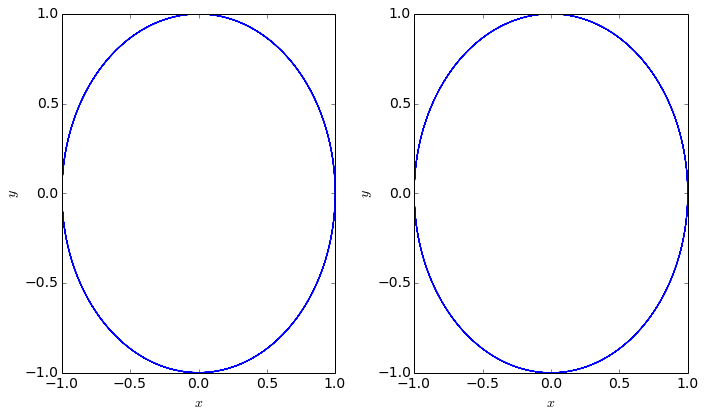

In [4]:
def fn_circular_motion(x, y):
    """Simple function for circular motion example"""
    
    dfdt = np.zeros_like(y)
    dfdt[0] = -y[1]
    dfdt[1] =  y[0]
    
    return dfdt

# Example given above
y0 = np.array([1.0, 0.0])
t_0_1, y_0_1 = am5_method(fn_circular_motion, 50.0, y0, 500)
t_0_01, y_0_01 = am5_method(fn_circular_motion, 50.0, y0, 5000)

  
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(121)
ax1.plot(y_0_1[:, 0], y_0_1[:, 1], 'b-', label = '$h = 0.1$')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2 = fig.add_subplot(122)
ax2.plot(y_0_01[:, 0], y_0_01[:, 1], 'b-', label = '$h = 0.01$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
fig.tight_layout()
plt.show()

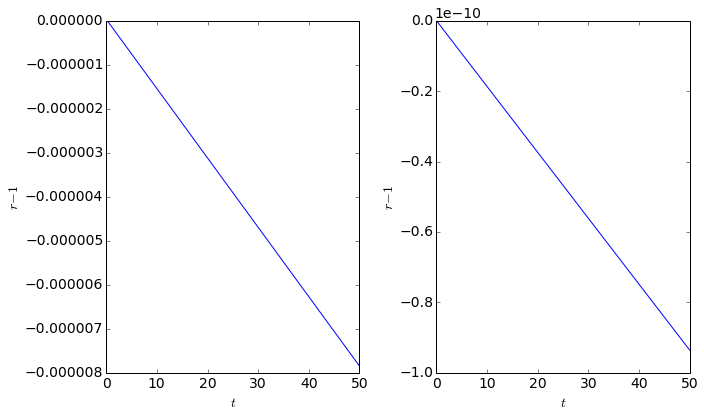

In [5]:
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(121)
ax1.plot(t_0_1, np.sqrt(y_0_1[:, 0]**2 + y_0_1[:, 1]**2)-1.0, 'b-', label = '$h = 0.1$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$r - 1$')
ax2 = fig.add_subplot(122)
ax2.plot(t_0_01, np.sqrt(y_0_01[:, 0]**2 + y_0_01[:, 1]**2)-1.0, 'b-', label = '$h = 0.01$')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$r - 1$')
fig.tight_layout()
plt.show()

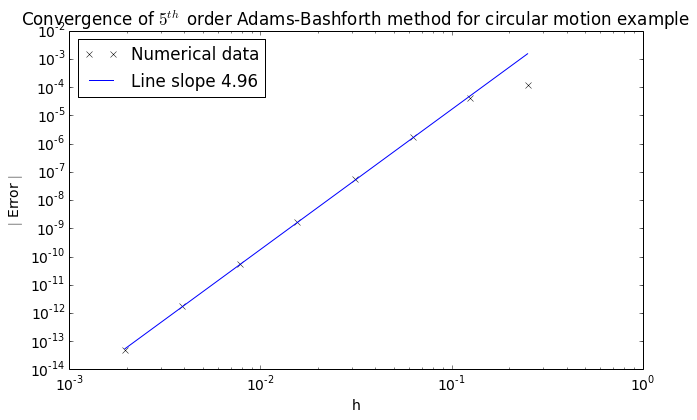

In [6]:
Npoints = np.array([50*2**i for i in range(2, 10)])
h = np.zeros_like(Npoints, float)
h = 50.0 / Npoints
err = np.zeros_like(h)

for i in range(len(Npoints)):
    N = Npoints[i]
    x, y = am5_method(fn_circular_motion, 50.0, y0, N)
    err[i] = np.abs(y[-1, 0]**2 + y[-1, 1]**2 - 1.0)

# Find the best fit to the data: if err ~ A h^s then the best fit straight line of log(err) vs log(h) has slope s.
p = np.polyfit(np.log(h[1:]), np.log(err[1:]), 1)
    
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.loglog(h, err, 'kx', label = 'Numerical data')
ax.loglog(h, np.exp(p[1])*h**(p[0]), 'b-', label = "Line slope {:.2f}".format(p[0]))
ax.set_xlabel('h')
ax.set_ylabel('$\|$ Error $\|$')
ax.set_title("Convergence of $5^{th}$ order Adams-Bashforth method for circular motion example")
ax.legend(loc = 2)
fig.tight_layout()
plt.show()

Order of multistep methods
--------------------------

A $k$-step multistep method should be $k^{\text{th}}$ order accurate as
$k^{\text{th}}$ order polynomials are exactly represented. To check
compute the local truncation error.

For the general $k$-step method

$$a_k y_{n+1} + a_{k-1} y_n + \dots + a_0 y_{n+1-k} = h \left[ b_k f_{n+1} + b_{k-1} f_n + \dots + b_0 f_{n+1-k} \right]$$

use the linear functional

$$L(y) = \sum_{p=0}^k \left[ a_p y(x_{n-k} + p h) - h b_p y'(x_{n-k}+ ph) \right].$$

Substitute $y' = f(x, y)$ to see that the functional represents the
$k$-step formula. Leading order term therefore gives the local
truncation error.

Another way of thinking about the functional is the following. The local
truncation error is given by $| y_{n+1} - y(x_{n+1}) |$, assuming that
$y_n, y_{n-1}, \dots$ are all exact. We can then write

\begin{align}
  \text{Error} & \propto | a_k \left( y_{n+1} - y(x_{n+1}) \right) |
  \\
  & = | -a_k y(x_{n+1}) + h \sum_{p=0}^k b_p f_{n+1-k+p} -
  \sum_{\ell=0}^{k-1} a_p y_{n+1-k+p} | 
\end{align}
using the $k$-step formula, then
\begin{align}
  & = | -a_k y(x_{n+1}) + h \sum_{p=0}^k b_p y'(x_{n+1-k+p}) -
  \sum_{\ell=0}^{k-1} a_p y(x_{n+1-k+p}) | \\
\end{align}
from the IVP $y' = f$, and using that $y_n$ etc. are exact,
\begin{align}
  & = | \sum_{p=0}^k \left[ a_p y(x_{n-k} + p h) - h b_p y'(x_{n-k} +
ph) \right] |
\end{align}

by re-ordering the sum and shifting the location of the $x_n$ points
(which we are free to do).

### Local truncation error of multistep methods

Take the Taylor series expansion of both $y$ and $y'$,

$$y(x_0 + p h)  = \sum_j \frac{(p h)^j}{j!} y^{(j)}(x_0), \quad y'(x_0 + p h) = \sum_j \frac{(p h)^j}{j!} y^{(j+1)}(x_0),$$

and substitute in the linear functional

$$L(y) = \sum_{p=0}^k \left[ a_p y(x_{n-k} + p h) - h b_p y'(x_{n-k} + ph) \right]$$

to give

$$L(y) = d_0 y(x_0) + d_1 h y'(x_0) + d_2 h^2 y''(x_0) + \dots$$

Expect that the first $k$ coefficients should vanish in a $k$-step
method.

### Relating the coefficients

The $k$-step method depends on the $a_m$ and $b_m$ coefficients; the
accuracy of the method depends on the $d_m$ coefficients. By matching
terms in the Taylor expansion get

$$\begin{aligned}
d_0 & = \sum_{p=0}^k a_p, \\ 
d_1 & = \sum_{p=0}^k p a_p - b_p, \\
d_2 & = \sum_{p=0}^k \frac{p^2}{2} a_p - p b_p,
\end{aligned}$$

and in general

$$d_j = \sum_{p=0}^k \left( \frac{p^j}{j!} a_p - \frac{p^{j-1}}{(j-1)!} b_p \right), \quad j \geq 2.$$

### Example

For the two step Adams-Bashforth method have 

$$y_{n+1} - y_n = \frac{h}{2} \left[ 3 f_n - f_{n-1} \right].$$

Equivalent to the coefficients 

$$a_2 = 1, \,\, a_1 = -1, \quad b_1 = 3/2, \,\, b_0 = -1/2.$$


From this compute the $d_m$ coefficients:

$$\begin{aligned}
d_0 & = \textstyle\sum_{p=0}^k a_p = (1 - 1) = 0, \\
d_1 & = \textstyle\sum_{p=0}^k p a_p - b_p = \left(2 - 1
\right) - \left( 3/2 - 1/2 \right) = 0, \\
d_2 & = \textstyle\sum_{p=0}^k \tfrac{p^2}{2} a_p - p b_p =
\left( 2 - 1/2 \right) - \left( 3/2 + 0 \right) = 0, \\
d_3 & = \textstyle\sum_{p=0}^k \tfrac{p^3}{6} a_p -
\tfrac{p^2}{2} b_p = \left( 4/3 - 1/6 \right) - \left( 1/2 \cdot
  3/2 \right) \neq 0. 
\end{aligned}$$

Hence the local truncation error is ${\cal O}(h^3)$ and the global
truncation error ${\cal O}(h^2)$.

### Example: Milne’s method

Milne’s method represents $y'$ using central differencing and the
integral with Simpson’s rule:

$$y_{n+1} - y_{n-1} = \frac{h}{3} \left( f_{n+1} + 4 f_{n} + f_{n-1} \right).$$

This is a $k$-step method with coefficients

$$\begin{aligned}
a_0 & = -1, & a_1 & = 0, & a_2 & = 1, \\
b_0 & = 1/3, & b_1 & = 4/3, & b_2 & = 1/3.
\end{aligned}$$

From this compute the accuracy coefficients

\begin{align}
  d_0 &= a_0 + a_1 + a_2 = 0,\\
  d_1 &= (0 a_0 - b_0) + (a_1 - b_1) + (2 a_2 - b_2) = 0,\\
  d_2 &= (0 a_0 - 0 b_0) + (\frac{1}{2} a_1 - b_1) +(\frac{2^2}{2} a_2 - 2 b_2) = 0,\\
  d_3 &= (0 a_0 - 0 b_0) + (\frac{1}{6} a_1 - \frac{1}{2} b_1) +(\frac{2^3}{6} a_2 - \frac{2^2}{2} b_2) = 0,\\
  d_4 &= (0 a_0 - 0 b_0) + (\frac{1}{24} a_1 - \frac{1}{6} b_1) +(\frac{2^4}{24} a_2 - \frac{2^3}{6} b_2) = 0,\\
  d_5 &= (0 a_0 - 0 b_0) + (\frac{1}{120} a_1 - \frac{1}{24} b_1) + (\frac{2^5}{120} a_2 - \frac{2^4}{24} b_2) \neq 0.
\end{align}

Hence the local truncation error is $\propto h^5$ giving a fourth
order method.

Summary
=======

-   Implicit multistep methods can be used in a predictor-corrector
fashion.

-   Typically the implicit *Adams-Moulton* methods use the explicit
Adams-Bashforth methods as a predictor, but any explicit method
(such as the Euler method) can be used.

-   To check the accuracy of a general $k$-step method we Taylor expand
the appropriate linear functional.

-   The functional gives the error made in taking a single step; its
local truncation error.

-   The coefficients of the linear functional $d_m$ are given by a
simple relation to the coefficients $a_m,b_m$ of the $k$-step
method.